# Individual Assignment: Non-Linear Classifier
## Network Intrusion Detection using Non-Linear Models

**Author:** Md Sohel Rana  
**TP Number:** TP087437  

**Classifier Category:** Non-Linear  
**Algorithms Evaluated:** K-Nearest Neighbors (KNN), Decision Tree, SVM (RBF Kernel)  
**Dataset:** NSL-KDD (Boosted Train + Preprocessed Test)  
**Classification:** Multi-class (5 attack categories)

---
## 1. Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
import warnings
warnings.filterwarnings('ignore')

import os
data_path = '../data'

In [2]:
# Import local library (provided helper functions)
import sys
if "../.." not in sys.path:
    sys.path.insert(0, '..')

from mylib import show_labels_dist, show_metrics, bias_var_metrics

In [3]:
# Additional imports for models and evaluation
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, matthews_corrcoef, confusion_matrix,
                             classification_report, ConfusionMatrixDisplay,
                             roc_curve, auc, roc_auc_score)
import json

---
## 2. Load Dataset

In [4]:
# Load Boosted Train and Preprocessed Test datasets
data_file = os.path.join(data_path, 'NSL_boosted-2.csv')
train_df = pd.read_csv(data_file)
print('Train Dataset: {} rows, {} columns'.format(train_df.shape[0], train_df.shape[1]))

data_file = os.path.join(data_path, 'NSL_ppTest.csv')
test_df = pd.read_csv(data_file)
print('Test Dataset: {} rows, {} columns'.format(test_df.shape[0], test_df.shape[1]))

Train Dataset: 63280 rows, 43 columns
Test Dataset: 22544 rows, 43 columns


In [5]:
train_df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,atakcat
0,0,tcp,http,REJ,0,0,0,0,0,0,...,1.00,0.00,0.03,0.05,0.00,0.0,1.00,0.37,normal,benign
1,0,tcp,ftp_data,SF,190,0,0,0,0,0,...,0.22,0.03,0.22,0.00,0.00,0.0,0.00,0.00,normal,benign
2,0,tcp,nnsp,S0,0,0,0,0,0,0,...,0.07,0.07,0.00,0.00,1.00,1.0,0.00,0.00,neptune,dos
3,0,tcp,http,SF,207,342,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,normal,benign
4,0,icmp,ecr_i,SF,1480,0,0,1,0,0,...,0.07,0.08,0.07,0.00,0.54,0.0,0.01,0.00,pod,dos


---
## 3. Data Preparation

In [6]:
# Check for missing values
print('Missing Values - Train Set:', train_df.isnull().sum().sum())
print('Missing Values - Test Set:', test_df.isnull().sum().sum())

Missing Values - Train Set: 0
Missing Values - Test Set: 0


In [7]:
# Combine datasets for consistent preprocessing
combined_df = pd.concat([train_df, test_df])
print('Combined Dataset: {} rows, {} columns'.format(combined_df.shape[0], combined_df.shape[1]))

Combined Dataset: 85824 rows, 43 columns


In [8]:
# Check label distributions
print("Attack category distribution:")
print(combined_df['atakcat'].value_counts())

Attack category distribution:
atakcat
benign    43383
dos       30524
probe      8332
r2l        3329
u2r         256
Name: count, dtype: int64


In [9]:
# MULTI-CLASS Classification (5 attack categories)
twoclass = False  # Use 5-class classification

if twoclass:
    labels_df = combined_df['label'].copy()
    labels_df[labels_df != 'normal'] = 'attack'
else:
    labels_df = combined_df['atakcat'].copy()

# Drop target features
combined_df.drop(['label'], axis=1, inplace=True)
combined_df.drop(['atakcat'], axis=1, inplace=True)

print(f"Classification: {'Binary' if twoclass else 'Multi-class (5 categories)'}")
print(f"\nClass distribution:")
print(labels_df.value_counts())

Classification: Multi-class (5 categories)

Class distribution:
atakcat
benign    43383
dos       30524
probe      8332
r2l        3329
u2r         256
Name: count, dtype: int64


In [10]:
# One-Hot Encoding categorical features
categori = combined_df.select_dtypes(include=['object']).columns
category_cols = categori.tolist()
features_df = pd.get_dummies(combined_df, columns=category_cols)
print('Features after encoding: {} columns'.format(features_df.shape[1]))

Features after encoding: 122 columns


In [11]:
# Get numeric columns for scaling
numeri = combined_df.select_dtypes(include=['float64','int64']).columns

In [12]:
# Restore train/test split
X_train = features_df.iloc[:len(train_df),:].copy()
X_train.reset_index(inplace=True, drop=True)
X_test = features_df.iloc[len(train_df):,:].copy()
X_test.reset_index(inplace=True, drop=True)

y_train = labels_df[:len(train_df)].copy()
y_train.reset_index(inplace=True, drop=True)
y_test = labels_df[len(train_df):].copy()
y_test.reset_index(inplace=True, drop=True)

print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

X_train: (63280, 122), y_train: (63280,)
X_test: (22544, 122), y_test: (22544,)


In [13]:
# Apply MinMaxScaler
for i in numeri:
    arr = np.array(X_train[i])
    scale = MinMaxScaler().fit(arr.reshape(-1, 1))
    X_train[i] = scale.transform(arr.reshape(len(arr),1))
    
    arr = np.array(X_test[i])
    X_test[i] = scale.transform(arr.reshape(len(arr),1))

print("Scaling completed using MinMaxScaler")

Scaling completed using MinMaxScaler


In [14]:
# Save original datasets
X_train_original = X_train.copy()
X_test_original = X_test.copy()

# Define class labels
class_labels = ['benign', 'dos', 'probe', 'r2l', 'u2r']
print(f"Class labels: {class_labels}")

Class labels: ['benign', 'dos', 'probe', 'r2l', 'u2r']


In [15]:
# Show label distribution
show_labels_dist(X_train, X_test, y_train, y_test)

features_train: 63280 rows, 122 columns
features_test:  22544 rows, 122 columns

labels_train: 63280 rows, 1 column
labels_test:  22544 rows, 1 column



Frequency and Distribution of labels
         atakcat  %_train  atakcat  %_test
atakcat                                   
benign     33672    53.21     9711   43.08
dos        23066    36.45     7458   33.08
probe       5911     9.34     2421   10.74
r2l          575     0.91     2754   12.22
u2r           56     0.09      200    0.89


---
## 4. BASELINE MODEL COMPARISON

### Non-Linear Algorithms to Evaluate:
1. **K-Nearest Neighbors (KNN)** - Instance-based learning
2. **Decision Tree** - Rule-based classification
3. **SVM (RBF Kernel)** - Support Vector Machine with non-linear kernel

We will compare all three baselines and select the best one for optimization.

In [16]:
# Helper function to calculate MCC per class
def calculate_mcc_per_class(y_true, y_pred, classes):
    """Calculate MCC for each class (one-vs-rest)"""
    mcc_dict = {}
    for cls in classes:
        mcc_dict[cls] = matthews_corrcoef(y_true == cls, y_pred == cls)
    return mcc_dict

### 4.1 Baseline 1: K-Nearest Neighbors (KNN)

In [17]:
print("="*60)
print("BASELINE 1: K-NEAREST NEIGHBORS (KNN)")
print("="*60)

# Using n_neighbors=5 (default), weights='distance' for better handling of imbalance
knn_baseline = KNeighborsClassifier(n_neighbors=5, weights='distance', n_jobs=-1)
print("Model:", knn_baseline)
print("\nKey Parameters:")
print(f"  - n_neighbors: 5")
print(f"  - weights: distance")

# Train and evaluate
trs = time()
knn_baseline.fit(X_train, y_train)
y_pred_knn = knn_baseline.predict(X_test)
knn_train_time = time() - trs

print(f"\nTraining Time: {knn_train_time:.2f} seconds\n")
show_metrics(y_test, y_pred_knn, class_labels)

BASELINE 1: K-NEAREST NEIGHBORS (KNN)
Model: KNeighborsClassifier(n_jobs=-1, weights='distance')

Key Parameters:
  - n_neighbors: 5
  - weights: distance



Training Time: 6.99 seconds

              pred:benign  pred:dos  pred:probe  pred:r2l  pred:u2r
train:benign         8876        65         619       147         4
train:dos             243      7183          32         0         0
train:probe           212        72        2128         1         8
train:r2l            2001       227           5       518         3
train:u2r              35         0           0         2       163

~~~~
      benign :  FPR = 0.194   FNR = 0.086
         dos :  FPR = 0.024   FNR = 0.037
       probe :  FPR = 0.033   FNR = 0.121
         r2l :  FPR = 0.008   FNR = 0.812
         u2r :  FPR = 0.001   FNR = 0.185

   macro avg :  FPR = 0.052   FNR = 0.248
weighted avg :  FPR = 0.041   FNR = 0.163

~~~~


              precision    recall  f1-score   support

      benign      0.781     0.914     0.842      9711
         dos      0.952     0.963     0.957      7458
       probe      0.764     0.879     0.818      2421
         r2l      0.775     0.188     0.303      2754
         u2r      0.916     0.815     0.862       200

    accuracy                          0.837     22544
   macro avg      0.838     0.752     0.756     22544
weighted avg      0.836     0.837     0.812     22544

~~~~
MCC: Overall :  0.760
      benign :  0.713
         dos :  0.936
       probe :  0.796
         r2l :  0.349
         u2r :  0.863


'~~~~'

In [18]:
# Store KNN baseline metrics
knn_metrics = {
    'accuracy': accuracy_score(y_test, y_pred_knn),
    'f1_weighted': f1_score(y_test, y_pred_knn, average='weighted'),
    'f1_macro': f1_score(y_test, y_pred_knn, average='macro'),
    'mcc': matthews_corrcoef(y_test, y_pred_knn),
    'train_time': knn_train_time
}
print("KNN Metrics:", knn_metrics)

KNN Metrics: {'accuracy': 0.8369410929737402, 'f1_weighted': 0.8119629596819908, 'f1_macro': 0.7564950888647546, 'mcc': 0.7601862969346245, 'train_time': 6.990372180938721}


### 4.2 Baseline 2: Decision Tree

In [19]:
print("="*60)
print("BASELINE 2: DECISION TREE")
print("="*60)

dt_baseline = DecisionTreeClassifier(class_weight='balanced', random_state=42)
print("Model:", dt_baseline)
print("\nKey Parameters:")
print(f"  - class_weight: balanced")
print(f"  - criterion: gini (default)")

# Train and evaluate
trs = time()
dt_baseline.fit(X_train, y_train)
y_pred_dt = dt_baseline.predict(X_test)
dt_train_time = time() - trs

print(f"\nTraining Time: {dt_train_time:.2f} seconds\n")
show_metrics(y_test, y_pred_dt, class_labels)

BASELINE 2: DECISION TREE
Model: DecisionTreeClassifier(class_weight='balanced', random_state=42)

Key Parameters:
  - class_weight: balanced
  - criterion: gini (default)



Training Time: 1.02 seconds

              pred:benign  pred:dos  pred:probe  pred:r2l  pred:u2r
train:benign         8804        92         671       135         9
train:dos             142      7263          38        15         0
train:probe           233        12        2174         2         0
train:r2l            2006         3           7       573       165
train:u2r              43         0           2         6       149

~~~~
      benign :  FPR = 0.189   FNR = 0.093
         dos :  FPR = 0.007   FNR = 0.026
       probe :  FPR = 0.036   FNR = 0.102
         r2l :  FPR = 0.008   FNR = 0.792
         u2r :  FPR = 0.008   FNR = 0.255

   macro avg :  FPR = 0.049   FNR = 0.254
weighted avg :  FPR = 0.040   FNR = 0.159

~~~~


              precision    recall  f1-score   support

      benign      0.784     0.907     0.841      9711
         dos      0.985     0.974     0.980      7458
       probe      0.752     0.898     0.818      2421
         r2l      0.784     0.208     0.329      2754
         u2r      0.461     0.745     0.570       200

    accuracy                          0.841     22544
   macro avg      0.753     0.746     0.708     22544
weighted avg      0.844     0.841     0.819     22544

~~~~
MCC: Overall :  0.767
      benign :  0.711
         dos :  0.970
       probe :  0.798
         r2l :  0.370
         u2r :  0.582


'~~~~'

In [20]:
# Store DT baseline metrics
dt_metrics = {
    'accuracy': accuracy_score(y_test, y_pred_dt),
    'f1_weighted': f1_score(y_test, y_pred_dt, average='weighted'),
    'f1_macro': f1_score(y_test, y_pred_dt, average='macro'),
    'mcc': matthews_corrcoef(y_test, y_pred_dt),
    'train_time': dt_train_time
}
print("Decision Tree Metrics:", dt_metrics)

Decision Tree Metrics: {'accuracy': 0.8411550745209369, 'f1_weighted': 0.8194250446400866, 'f1_macro': 0.707509914677878, 'mcc': 0.7673054312710094, 'train_time': 1.0228524208068848}


### 4.3 Baseline 3: SVM (RBF Kernel)

**Note:** SVM with RBF kernel is computationally expensive on large datasets. We use a subset for training if needed.

In [21]:
print("="*60)
print("BASELINE 3: SVM (RBF KERNEL)")
print("="*60)

# SVM with RBF kernel - using class_weight='balanced'
svm_baseline = SVC(kernel='rbf', class_weight='balanced', random_state=42)
print("Model:", svm_baseline)
print("\nKey Parameters:")
print(f"  - kernel: rbf")
print(f"  - class_weight: balanced")
print(f"  - C: 1.0 (default)")
print(f"  - gamma: scale (default)")

# Train and evaluate
trs = time()
svm_baseline.fit(X_train, y_train)
y_pred_svm = svm_baseline.predict(X_test)
svm_train_time = time() - trs

print(f"\nTraining Time: {svm_train_time:.2f} seconds\n")
show_metrics(y_test, y_pred_svm, class_labels)

BASELINE 3: SVM (RBF KERNEL)
Model: SVC(class_weight='balanced', random_state=42)

Key Parameters:
  - kernel: rbf
  - class_weight: balanced
  - C: 1.0 (default)
  - gamma: scale (default)



Training Time: 113.23 seconds

              pred:benign  pred:dos  pred:probe  pred:r2l  pred:u2r
train:benign         8768        58         527       298        60
train:dos             625      6673          72        60        28
train:probe           130       114        2163         0        14
train:r2l            1204       200           8      1230       112
train:u2r              14         0           0        17       169

~~~~
      benign :  FPR = 0.154   FNR = 0.097
         dos :  FPR = 0.025   FNR = 0.105
       probe :  FPR = 0.030   FNR = 0.107
         r2l :  FPR = 0.019   FNR = 0.553
         u2r :  FPR = 0.010   FNR = 0.155

   macro avg :  FPR = 0.047   FNR = 0.203
weighted avg :  FPR = 0.039   FNR = 0.157

~~~~


              precision    recall  f1-score   support

      benign      0.816     0.903     0.857      9711
         dos      0.947     0.895     0.920      7458
       probe      0.781     0.893     0.833      2421
         r2l      0.766     0.447     0.564      2754
         u2r      0.441     0.845     0.580       200

    accuracy                          0.843     22544
   macro avg      0.750     0.797     0.751     22544
weighted avg      0.846     0.843     0.837     22544

~~~~
MCC: Overall :  0.769
      benign :  0.743
         dos :  0.883
       probe :  0.814
         r2l :  0.545
         u2r :  0.606


'~~~~'

In [22]:
# Store SVM baseline metrics
svm_metrics = {
    'accuracy': accuracy_score(y_test, y_pred_svm),
    'f1_weighted': f1_score(y_test, y_pred_svm, average='weighted'),
    'f1_macro': f1_score(y_test, y_pred_svm, average='macro'),
    'mcc': matthews_corrcoef(y_test, y_pred_svm),
    'train_time': svm_train_time
}
print("SVM Metrics:", svm_metrics)

SVM Metrics: {'accuracy': 0.8429293825408091, 'f1_weighted': 0.8373492827782578, 'f1_macro': 0.7510241166966419, 'mcc': 0.7685135858348214, 'train_time': 113.23350882530212}


### 4.4 Baseline Comparison Summary

In [23]:
# Create comparison table
baseline_comparison = pd.DataFrame({
    'Algorithm': ['KNN', 'Decision Tree', 'SVM-RBF'],
    'Accuracy': [knn_metrics['accuracy'], dt_metrics['accuracy'], svm_metrics['accuracy']],
    'F1 (Weighted)': [knn_metrics['f1_weighted'], dt_metrics['f1_weighted'], svm_metrics['f1_weighted']],
    'F1 (Macro)': [knn_metrics['f1_macro'], dt_metrics['f1_macro'], svm_metrics['f1_macro']],
    'MCC': [knn_metrics['mcc'], dt_metrics['mcc'], svm_metrics['mcc']],
    'Train Time (s)': [knn_metrics['train_time'], dt_metrics['train_time'], svm_metrics['train_time']]
})

print("\n" + "="*70)
print("BASELINE COMPARISON: NON-LINEAR CLASSIFIERS")
print("="*70)
print(baseline_comparison.to_string(index=False))


BASELINE COMPARISON: NON-LINEAR CLASSIFIERS
    Algorithm  Accuracy  F1 (Weighted)  F1 (Macro)      MCC  Train Time (s)
          KNN  0.836941       0.811963    0.756495 0.760186        6.990372
Decision Tree  0.841155       0.819425    0.707510 0.767305        1.022852
      SVM-RBF  0.842929       0.837349    0.751024 0.768514      113.233509


In [24]:
# MCC per class for each baseline
print("\n" + "="*70)
print("MCC PER ATTACK CLASS")
print("="*70)

knn_mcc_class = calculate_mcc_per_class(y_test, y_pred_knn, class_labels)
dt_mcc_class = calculate_mcc_per_class(y_test, y_pred_dt, class_labels)
svm_mcc_class = calculate_mcc_per_class(y_test, y_pred_svm, class_labels)

mcc_per_class_df = pd.DataFrame({
    'Attack Class': class_labels,
    'KNN': [knn_mcc_class[c] for c in class_labels],
    'Decision Tree': [dt_mcc_class[c] for c in class_labels],
    'SVM-RBF': [svm_mcc_class[c] for c in class_labels]
})
print(mcc_per_class_df.to_string(index=False))


MCC PER ATTACK CLASS


Attack Class      KNN  Decision Tree  SVM-RBF
      benign 0.712995       0.710803 0.742756
         dos 0.936211       0.969691 0.883218
       probe 0.796488       0.798357 0.814146
         r2l 0.348606       0.369901 0.544631
         u2r 0.862762       0.581708 0.606188


In [25]:
# Bias-Variance Decomposition - Best baseline only (for computational efficiency)
print("\n" + "="*70)
print("BIAS-VARIANCE DECOMPOSITION (3-fold bootstrap) - KNN")
print("="*70)

print("\nKNN:")
bias_var_metrics(X_train, X_test, y_train, y_test, 
                 KNeighborsClassifier(n_neighbors=5, weights='distance', n_jobs=-1), 
                 folds=3)


BIAS-VARIANCE DECOMPOSITION (3-fold bootstrap) - KNN

KNN:


   Average bias: 0.167
   Average variance: 0.013
   Average expected loss: 0.166  "Goodness": 0.834



In [26]:
# Select best baseline
best_baseline_name = baseline_comparison.loc[baseline_comparison['MCC'].idxmax(), 'Algorithm']
best_baseline_mcc = baseline_comparison['MCC'].max()

print("\n" + "="*70)
print("BEST BASELINE SELECTION")
print("="*70)
print(f"\nBest Baseline: {best_baseline_name}")
print(f"MCC Score: {best_baseline_mcc:.4f}")
print("\nJustification: MCC is selected as the primary metric because it is")
print("more informative for imbalanced datasets (Chicco & Jurman, 2020).")


BEST BASELINE SELECTION

Best Baseline: SVM-RBF
MCC Score: 0.7685

Justification: MCC is selected as the primary metric because it is
more informative for imbalanced datasets (Chicco & Jurman, 2020).


---
## 5. OPTIMISATION STRATEGY 1: Hyperparameter Tuning

### Hyperparameter Justification Table (KNN)

| Parameter | Values Tested | Justification | Reference |
|-----------|---------------|---------------|-----------|
| n_neighbors | 3, 5, 7, 9 | Odd values prevent ties; small k for local patterns | Cover & Hart (1967) |
| weights | uniform, distance | Distance weighting gives local influence | Hastie et al. (2009) |
| p | 1, 2 | Manhattan (1) vs Euclidean (2) distance | Aggarwal et al. (2001) |
| algorithm | ball_tree, kd_tree, auto | Search efficiency | scikit-learn docs |

**References:**
- Cover, T., & Hart, P. (1967). Nearest neighbor pattern classification.
- Aggarwal, C. C., et al. (2001). On the surprising behavior of distance metrics in high dimensional space.
- Hastie, T., Tibshirani, R., & Friedman, J. (2009). The Elements of Statistical Learning.

In [27]:
print("="*60)
print("HYPERPARAMETER TUNING: KNN")
print("="*60)

# Parameter grid
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'p': [1, 2],  # 1=Manhattan, 2=Euclidean
    'algorithm': ['auto']
}

print("Parameter grid:")
for k, v in param_grid.items():
    print(f"  {k}: {v}")

# Use GridSearchCV
print("\nRunning GridSearchCV (3-fold CV)...")

knn_grid = GridSearchCV(
    estimator=KNeighborsClassifier(n_jobs=-1),
    param_grid=param_grid,
    cv=3,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)

trs = time()
knn_grid.fit(X_train, y_train)
tune_time = time() - trs

print(f"\nTuning Time: {tune_time:.2f} seconds")
print(f"\nBest Parameters: {knn_grid.best_params_}")
print(f"Best CV Score: {knn_grid.best_score_:.4f}")

HYPERPARAMETER TUNING: KNN
Parameter grid:
  n_neighbors: [3, 5, 7, 9]
  weights: ['uniform', 'distance']
  p: [1, 2]
  algorithm: ['auto']

Running GridSearchCV (3-fold CV)...
Fitting 3 folds for each of 16 candidates, totalling 48 fits



Tuning Time: 894.58 seconds

Best Parameters: {'algorithm': 'auto', 'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
Best CV Score: 0.9921


In [28]:
best_params = knn_grid.best_params_

---
## 6. OPTIMISATION STRATEGY 2: Feature Selection (Correlation-based)

For KNN, reducing features improves both speed and performance by removing noisy dimensions.

**Method:** Correlation-based feature selection
- Select features with high correlation to target

**Reference:** Chandrashekar, G., & Sahin, F. (2014). A survey on feature selection methods.

In [29]:
# Encode target for correlation analysis
y_encoded = LabelEncoder().fit_transform(y_train)

# Create dataframe with features and encoded target
corr_df = X_train.copy()
corr_df['target'] = y_encoded

# Calculate correlation with target
correlations = corr_df.corr()['target'].drop('target').abs().sort_values(ascending=False)
print("Top 20 features correlated with target:")
print(correlations.head(20))

Top 20 features correlated with target:
dst_host_srv_count             0.616523
logged_in                      0.570013
flag_SF                        0.536702
dst_host_same_srv_rate         0.518253
service_http                   0.507994
same_srv_rate                  0.497750
service_private                0.396330
dst_host_diff_srv_rate         0.390385
count                          0.375244
dst_host_srv_serror_rate       0.373193
dst_host_serror_rate           0.370709
serror_rate                    0.370174
srv_serror_rate                0.367315
flag_S0                        0.362105
service_eco_i                  0.334847
dst_host_same_src_port_rate    0.313174
dst_host_srv_rerror_rate       0.308995
srv_rerror_rate                0.307498
rerror_rate                    0.306686
protocol_type_icmp             0.291532
Name: target, dtype: float64


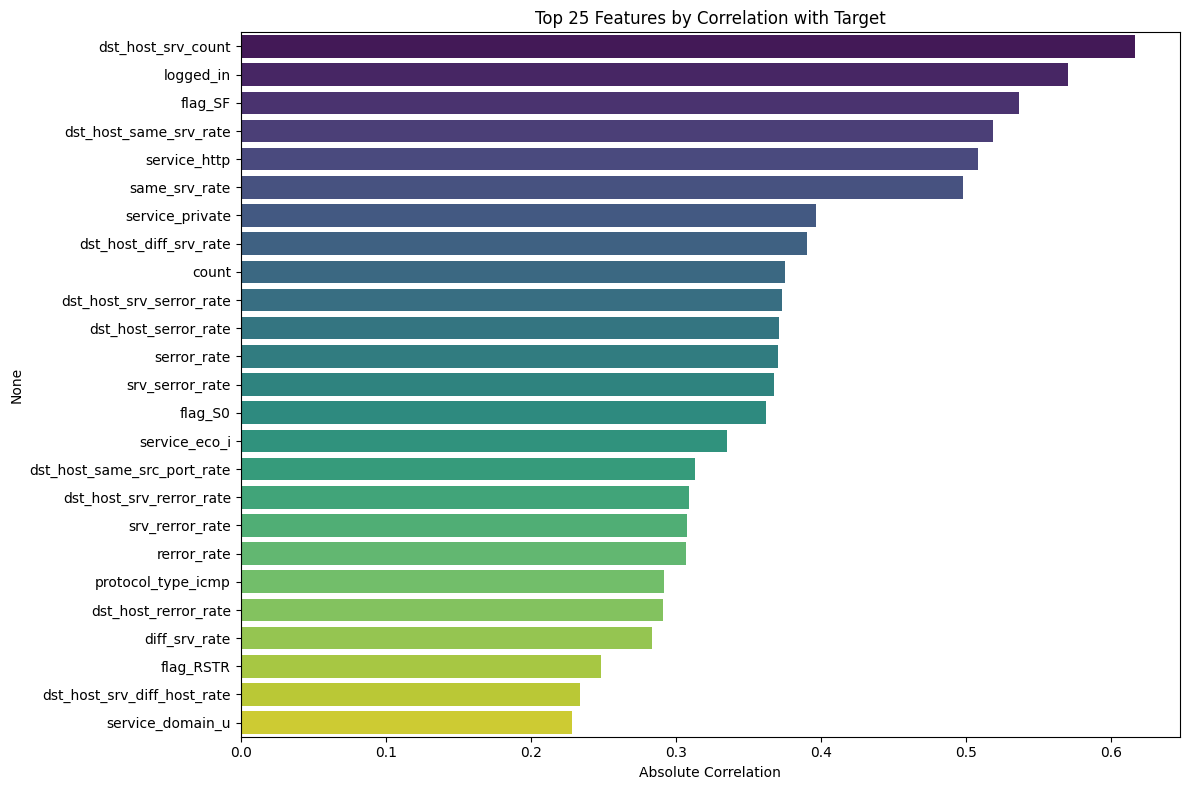

In [30]:
# Visualize top correlations (for appendix)
plt.figure(figsize=(12, 8))
top_features = correlations.head(25)
sns.barplot(x=top_features.values, y=top_features.index, palette='viridis')
plt.title('Top 25 Features by Correlation with Target')
plt.xlabel('Absolute Correlation')
plt.tight_layout()
plt.savefig('../figures/nonlinear_feature_correlation.png', dpi=150)
plt.show()

In [31]:
# Select features with correlation > threshold
threshold = 0.1
selected_features = correlations[correlations > threshold].index.tolist()

# Ensure minimum features
if len(selected_features) < 20:
    selected_features = correlations.head(20).index.tolist()

print(f"\nFeature Selection Results:")
print(f"  - Original features: {X_train.shape[1]}")
print(f"  - Selected features: {len(selected_features)}")
print(f"  - Reduction: {((X_train.shape[1] - len(selected_features)) / X_train.shape[1] * 100):.1f}%")


Feature Selection Results:
  - Original features: 122
  - Selected features: 30
  - Reduction: 75.4%


In [32]:
# Create reduced datasets
X_train_reduced = X_train[selected_features]
X_test_reduced = X_test[selected_features]
print(f"Reduced feature set: {X_train_reduced.shape[1]} features")

Reduced feature set: 30 features


---
## 7. OPTIMISED MODEL

In [33]:
# Create optimised model
optimised_model = KNeighborsClassifier(**best_params, n_jobs=-1)

print("="*60)
print("OPTIMISED MODEL EVALUATION")
print("="*60)
print(f"Parameters: {best_params}")
print(f"Features: {len(selected_features)} (reduced from {X_train.shape[1]})")

trs = time()
optimised_model.fit(X_train_reduced, y_train)
y_pred_optimised = optimised_model.predict(X_test_reduced)
opt_train_time = time() - trs

print(f"\nTraining Time: {opt_train_time:.2f} seconds\n")
show_metrics(y_test, y_pred_optimised, class_labels)

OPTIMISED MODEL EVALUATION
Parameters: {'algorithm': 'auto', 'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
Features: 30 (reduced from 122)



Training Time: 13.37 seconds

              pred:benign  pred:dos  pred:probe  pred:r2l  pred:u2r
train:benign         9151        72         299       182         7
train:dos             230      7181          46         1         0
train:probe           233        21        2120         3        44
train:r2l            1370       169           6      1155        54
train:u2r              75         0           1         1       123

~~~~
      benign :  FPR = 0.149   FNR = 0.058
         dos :  FPR = 0.017   FNR = 0.037
       probe :  FPR = 0.017   FNR = 0.124
         r2l :  FPR = 0.009   FNR = 0.581
         u2r :  FPR = 0.005   FNR = 0.385

   macro avg :  FPR = 0.040   FNR = 0.237
weighted avg :  FPR = 0.031   FNR = 0.125

~~~~


              precision    recall  f1-score   support

      benign      0.827     0.942     0.881      9711
         dos      0.965     0.963     0.964      7458
       probe      0.858     0.876     0.867      2421
         r2l      0.861     0.419     0.564      2754
         u2r      0.539     0.615     0.575       200

    accuracy                          0.875     22544
   macro avg      0.810     0.763     0.770     22544
weighted avg      0.878     0.875     0.865     22544

~~~~
MCC: Overall :  0.816
      benign :  0.786
         dos :  0.946
       probe :  0.850
         r2l :  0.567
         u2r :  0.572


'~~~~'

In [34]:
# Bias-Variance Decomposition for optimised model
print("\nBias-Variance Decomposition (Optimised):")
bias_var_metrics(X_train_reduced, X_test_reduced, y_train, y_test, 
                 KNeighborsClassifier(**best_params, n_jobs=-1), folds=3)


Bias-Variance Decomposition (Optimised):


   Average bias: 0.127
   Average variance: 0.014
   Average expected loss: 0.128  "Goodness": 0.872



In [35]:
# Store optimised metrics
optimised_metrics = {
    'accuracy': accuracy_score(y_test, y_pred_optimised),
    'f1_weighted': f1_score(y_test, y_pred_optimised, average='weighted'),
    'f1_macro': f1_score(y_test, y_pred_optimised, average='macro'),
    'mcc': matthews_corrcoef(y_test, y_pred_optimised),
    'train_time': opt_train_time
}
print("Optimised Metrics:", optimised_metrics)

# MCC per class
opt_mcc_class = calculate_mcc_per_class(y_test, y_pred_optimised, class_labels)
print("\nMCC per class (Optimised):")
for cls, mcc in opt_mcc_class.items():
    print(f"  {cls}: {mcc:.4f}")

Optimised Metrics: {'accuracy': 0.8751774308019872, 'f1_weighted': 0.8654778429406811, 'f1_macro': 0.7700555887432005, 'mcc': 0.8160588737870642, 'train_time': 13.371395349502563}

MCC per class (Optimised):
  benign: 0.7861
  dos: 0.9460
  probe: 0.8504
  r2l: 0.5674
  u2r: 0.5720


---
## 8. COMPARISON: Baseline vs Optimised Model

In [36]:
# Comparison table
comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'F1 (Weighted)', 'F1 (Macro)', 'MCC', 'Train Time (s)'],
    'Baseline': [knn_metrics['accuracy'], knn_metrics['f1_weighted'], 
                 knn_metrics['f1_macro'], knn_metrics['mcc'], knn_metrics['train_time']],
    'Optimised': [optimised_metrics['accuracy'], optimised_metrics['f1_weighted'],
                  optimised_metrics['f1_macro'], optimised_metrics['mcc'], 
                  optimised_metrics['train_time']]
})
comparison_df['Improvement'] = comparison_df['Optimised'] - comparison_df['Baseline']
comparison_df['Improvement %'] = (comparison_df['Improvement'] / comparison_df['Baseline'] * 100).round(2)

print("\n" + "="*60)
print("PERFORMANCE COMPARISON: BASELINE vs OPTIMISED")
print("="*60)
print(comparison_df.to_string(index=False))


PERFORMANCE COMPARISON: BASELINE vs OPTIMISED
        Metric  Baseline  Optimised  Improvement  Improvement %
      Accuracy  0.836941   0.875177     0.038236           4.57
 F1 (Weighted)  0.811963   0.865478     0.053515           6.59
    F1 (Macro)  0.756495   0.770056     0.013560           1.79
           MCC  0.760186   0.816059     0.055873           7.35
Train Time (s)  6.990372  13.371395     6.381023          91.28


In [37]:
# MCC per class comparison
mcc_comparison_df = pd.DataFrame({
    'Attack Class': class_labels,
    'Baseline': [knn_mcc_class[c] for c in class_labels],
    'Optimised': [opt_mcc_class[c] for c in class_labels]
})
mcc_comparison_df['Improvement'] = mcc_comparison_df['Optimised'] - mcc_comparison_df['Baseline']

print("\n" + "="*60)
print("MCC PER CLASS: BASELINE vs OPTIMISED")
print("="*60)
print(mcc_comparison_df.to_string(index=False))


MCC PER CLASS: BASELINE vs OPTIMISED
Attack Class  Baseline  Optimised  Improvement
      benign  0.712995   0.786147     0.073153
         dos  0.936211   0.945974     0.009763
       probe  0.796488   0.850358     0.053871
         r2l  0.348606   0.567363     0.218757
         u2r  0.862762   0.571958    -0.290805


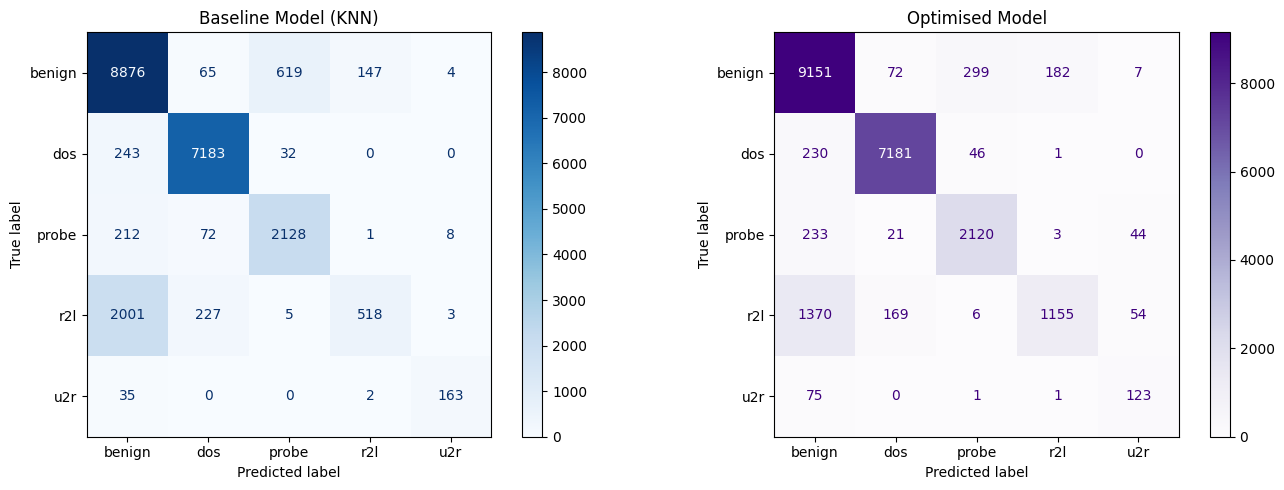

In [38]:
# Confusion Matrix (for appendix)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

cm_baseline = confusion_matrix(y_test, y_pred_knn, labels=class_labels)
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_baseline, display_labels=class_labels)
disp1.plot(ax=axes[0], cmap='Blues', values_format='d')
axes[0].set_title('Baseline Model (KNN)')

cm_optimised = confusion_matrix(y_test, y_pred_optimised, labels=class_labels)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_optimised, display_labels=class_labels)
disp2.plot(ax=axes[1], cmap='Purples', values_format='d')
axes[1].set_title('Optimised Model')

plt.tight_layout()
plt.savefig('../figures/nonlinear_confusion_matrices.png', dpi=150)
plt.show()

---
## 9. Summary and Conclusions

In [39]:
print("="*70)
print("SUMMARY: NON-LINEAR CLASSIFIER FOR INTRUSION DETECTION")
print("="*70)

print("\n1. CLASSIFIER CATEGORY: Non-Linear")
print("   Algorithms Evaluated: KNN, Decision Tree, SVM-RBF")
print(f"   Best Baseline: {best_baseline_name}")

print("\n2. CLASSIFICATION TYPE: Multi-class (5 categories)")

print("\n3. BASELINE COMPARISON:")
print(baseline_comparison.to_string(index=False))

print("\n4. OPTIMISATION STRATEGIES:")
print("   a) Hyperparameter Tuning with GridSearchCV")
for k, v in best_params.items():
    print(f"      - {k}: {v}")
print("   b) Feature Selection (Correlation-based)")
print(f"      - Original: {X_train.shape[1]} features")
print(f"      - Selected: {len(selected_features)} features")

print("\n5. PERFORMANCE IMPROVEMENT:")
for _, row in comparison_df.iterrows():
    if row['Metric'] != 'Train Time (s)':
        print(f"   {row['Metric']}: {row['Baseline']:.4f} -> {row['Optimised']:.4f} ({row['Improvement %']:+.2f}%)")

print("\n" + "="*70)

SUMMARY: NON-LINEAR CLASSIFIER FOR INTRUSION DETECTION

1. CLASSIFIER CATEGORY: Non-Linear
   Algorithms Evaluated: KNN, Decision Tree, SVM-RBF
   Best Baseline: SVM-RBF

2. CLASSIFICATION TYPE: Multi-class (5 categories)

3. BASELINE COMPARISON:
    Algorithm  Accuracy  F1 (Weighted)  F1 (Macro)      MCC  Train Time (s)
          KNN  0.836941       0.811963    0.756495 0.760186        6.990372
Decision Tree  0.841155       0.819425    0.707510 0.767305        1.022852
      SVM-RBF  0.842929       0.837349    0.751024 0.768514      113.233509

4. OPTIMISATION STRATEGIES:
   a) Hyperparameter Tuning with GridSearchCV
      - algorithm: auto
      - n_neighbors: 3
      - p: 1
      - weights: distance
   b) Feature Selection (Correlation-based)
      - Original: 122 features
      - Selected: 30 features

5. PERFORMANCE IMPROVEMENT:
   Accuracy: 0.8369 -> 0.8752 (+4.57%)
   F1 (Weighted): 0.8120 -> 0.8655 (+6.59%)
   F1 (Macro): 0.7565 -> 0.7701 (+1.79%)
   MCC: 0.7602 -> 0.8161 (+7.3

In [40]:
# Save results
results_dict = {
    'classifier': 'K-Nearest Neighbors',
    'category': 'Non-Linear',
    'classification_type': 'multi-class',
    'classes': class_labels,
    'baseline_comparison': baseline_comparison.to_dict('records'),
    'baseline_metrics': knn_metrics,
    'optimised_metrics': optimised_metrics,
    'baseline_mcc_per_class': knn_mcc_class,
    'optimised_mcc_per_class': opt_mcc_class,
    'optimisation_strategies': ['Hyperparameter Tuning', 'Feature Selection (Correlation)'],
    'best_params': {k: str(v) for k, v in best_params.items()},
    'n_features_original': X_train.shape[1],
    'n_features_selected': len(selected_features)
}

with open('../results/nonlinear_knn_results.json', 'w') as f:
    json.dump(results_dict, f, indent=2, default=str)
print("Results saved to: results/nonlinear_knn_results.json")

Results saved to: results/nonlinear_knn_results.json


In [41]:
# Save comparison tables
baseline_comparison.to_csv('../results/nonlinear_baseline_comparison.csv', index=False)
comparison_df.to_csv('../results/nonlinear_baseline_vs_optimised.csv', index=False)
mcc_comparison_df.to_csv('../results/nonlinear_mcc_per_class.csv', index=False)
print("CSV files saved.")

CSV files saved.
